In [1]:
import numpy as np
import matplotlib.pyplot as plt
from stl import mesh

In [5]:
Z_AXIS = 9.9
IMAGE_WIDTH = 180
IMAGE_HEIGHT = 140

In [9]:
def calculate_area_of_triangle(triangle_vertices):
    side1 = triangle_vertices[1] - triangle_vertices[0]
    side2 = triangle_vertices[2] - triangle_vertices[0]
    cross_product = np.cross(side1, side2)
    area = 0.5 * np.linalg.norm(cross_product)
    return area

In [11]:
stl_data = mesh.Mesh.from_file('../data/stl/rotated_image_45.stl')

In [12]:
triangles = stl_data.vectors

In [13]:
print(len(triangles))

5444


In [14]:
all_vertices = np.concatenate(triangles, axis=0)
max_x = np.max(all_vertices[:, 0])
max_y = np.max(all_vertices[:, 1])
max_z = np.max(all_vertices[:, 2])

Z_AXIS = 9.9
IMAGE_WIDTH = max_x
IMAGE_HEIGHT = max_y

In [15]:
# Find the triangles whose vertices lie on the Z-axis
z_axis_triangles = []

for triangle in triangles:
    vertex_1, vertex_2, vertex_3 = np.array_split(triangle, 3)
    vertex_1 = vertex_1.flatten()
    vertex_2 = vertex_2.flatten()
    vertex_3 = vertex_3.flatten()
    if (vertex_1[2] >= Z_AXIS) and (vertex_2[2] >= Z_AXIS) and (vertex_3[2] >= Z_AXIS):
        z_axis_triangles.append(triangle)

In [16]:
# Convert the list of triangles to a NumPy array
z_axis_triangles = np.array(z_axis_triangles)

In [17]:
print(len(z_axis_triangles))

3097


In [48]:
# Step 1: Divide Image into Sections (Grid-based Segmentation)
num_sections_x = 9
num_sections_y = 7
section_width = IMAGE_WIDTH // num_sections_x
section_height = IMAGE_HEIGHT // num_sections_y

In [44]:
# Step 2: Determine Triangle-Section Intersection
triangle_section_map = {}
for i in z_axis_triangles:
    for section_x in range(num_sections_x):
        for section_y in range(num_sections_y):
            section_left = section_x * section_width
            section_right = (section_x + 1) * section_width
            section_top = section_y * section_height
            section_bottom = (section_y + 1) * section_height
            for vertex in i:
                x, y, _ = vertex
                if section_left <= x < section_right and section_top <= y < section_bottom:
                    triangle_section_map.setdefault((section_x, section_y), []).append(i)
                    break

In [45]:
# Step 3: Count Triangles in Each Section
triangle_count_in_section = {section: len(triangles) for section, triangles in triangle_section_map.items()}

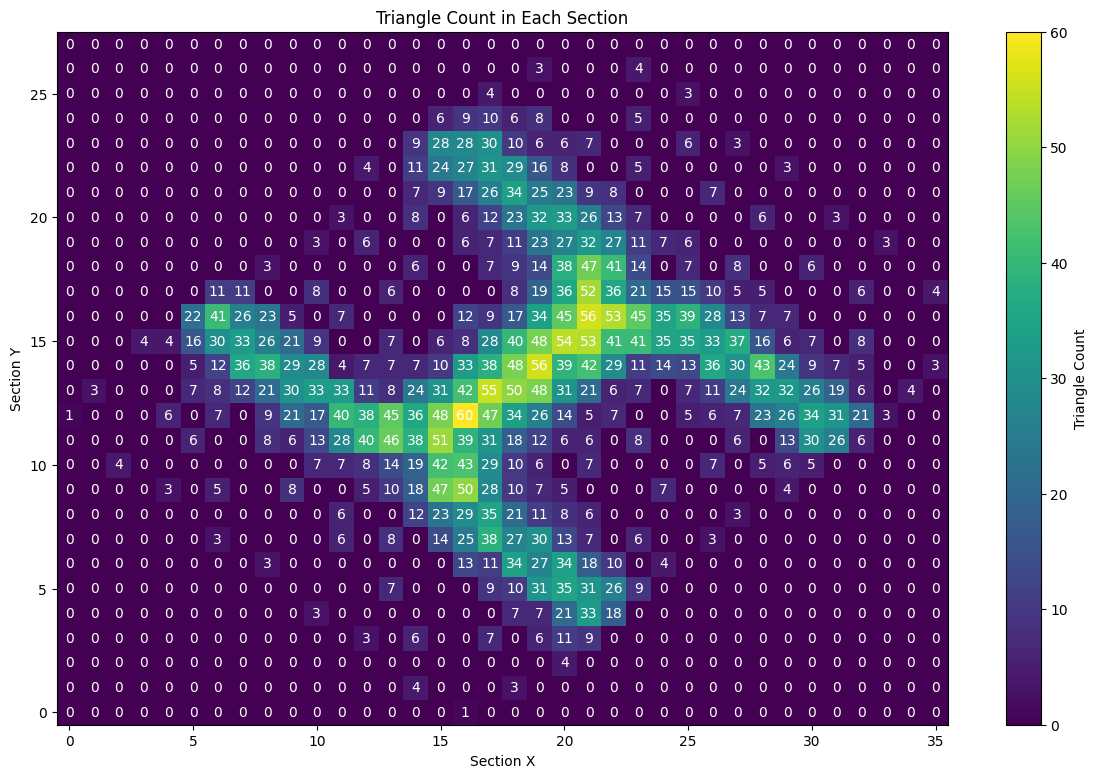

In [46]:
count_array = np.zeros((num_sections_y, num_sections_x), dtype=int)
for section_y in range(num_sections_y):
    for section_x in range(num_sections_x):
        count_array[section_y, section_x] = triangle_count_in_section.get((section_x, section_y), 0)

# Create a heatmap using matplotlib
plt.figure(figsize=(15,9))
plt.imshow(count_array, cmap='viridis', origin='lower', interpolation='nearest')
plt.colorbar(label='Triangle Count')
plt.xlabel('Section X')
plt.ylabel('Section Y')
plt.title('Triangle Count in Each Section')
#plt.grid(visible=False)
for section_y in range(num_sections_y):
    for section_x in range(num_sections_x):
        text = plt.text(section_x, section_y, f'{count_array[section_y, section_x]}',
                            ha='center', va='center', color='w')
plt.show()

581
747


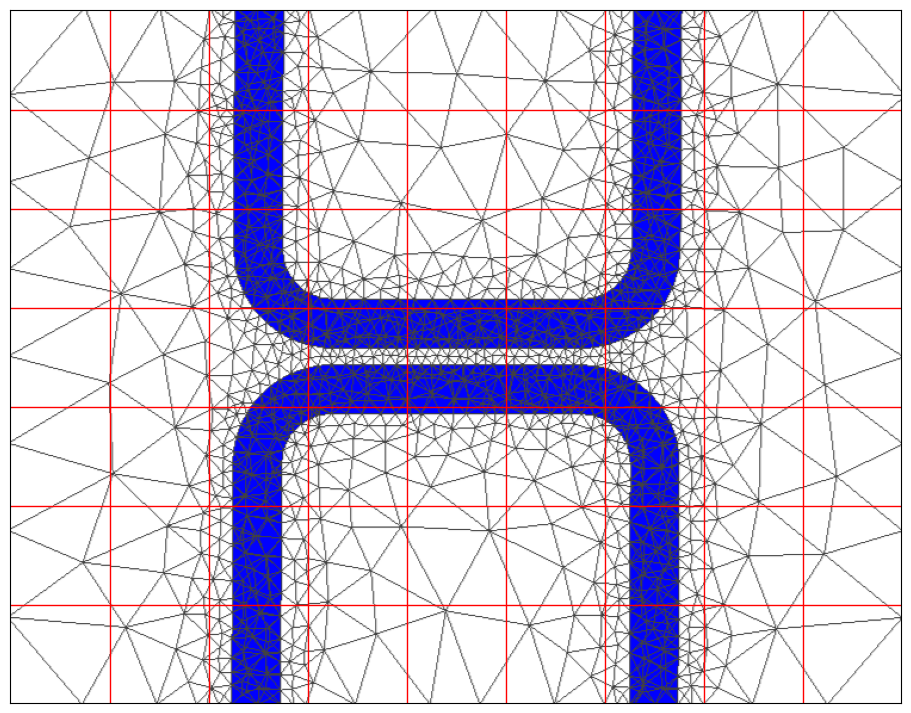

In [49]:
image = plt.imread('../data/images/Microstrip_Coupler_mesh.png')
height, width, _ = image.shape
print(height)
print(width)
grid_width = width // num_sections_x
grid_height = height // num_sections_y
# Create a new figure
fig, ax = plt.subplots(figsize=(15,9))

# Display the image
ax.imshow(image)

# Add the grid to the image
for x in range(grid_width, width, grid_width):
    ax.axvline(x, color='red', linewidth=1)

for y in range(grid_height, height, grid_height):
    ax.axhline(y, color='red', linewidth=1)

# Optionally, you can also hide the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

In [29]:
triangle_areas = [calculate_area_of_triangle(triangle) for triangle in z_axis_triangles]

In [30]:
# Step 5: Compute Minimum and Average Triangle Area for Each Section

min_triangle_area_in_section = {}
average_triangle_area_in_section = {}

for section_x in range(num_sections_x):
    for section_y in range(num_sections_y):
        section_triangles = triangle_section_map.get((section_x, section_y), [])
        if section_triangles:
            section_triangle_areas = [calculate_area_of_triangle(triangle) for triangle in section_triangles]
            min_triangle_area_in_section[(section_x, section_y)] = min(section_triangle_areas)
            average_triangle_area_in_section[(section_x, section_y)] = sum(section_triangle_areas) / len(section_triangle_areas)
        else:
            min_triangle_area_in_section[(section_x, section_y)] = 0
            average_triangle_area_in_section[(section_x, section_y)] = 0

In [31]:
# Convert min_triangle_area_in_section and average_triangle_area_in_section to NumPy arrays for heatmap visualization
min_area_array = np.zeros((num_sections_y, num_sections_x), dtype=float)
average_area_array = np.zeros((num_sections_y, num_sections_x), dtype=float)

for section_y in range(num_sections_y):
    for section_x in range(num_sections_x):
        min_area_array[section_y, section_x] = min_triangle_area_in_section.get((section_x, section_y), 0)
        average_area_array[section_y, section_x] = average_triangle_area_in_section.get((section_x, section_y), 0)

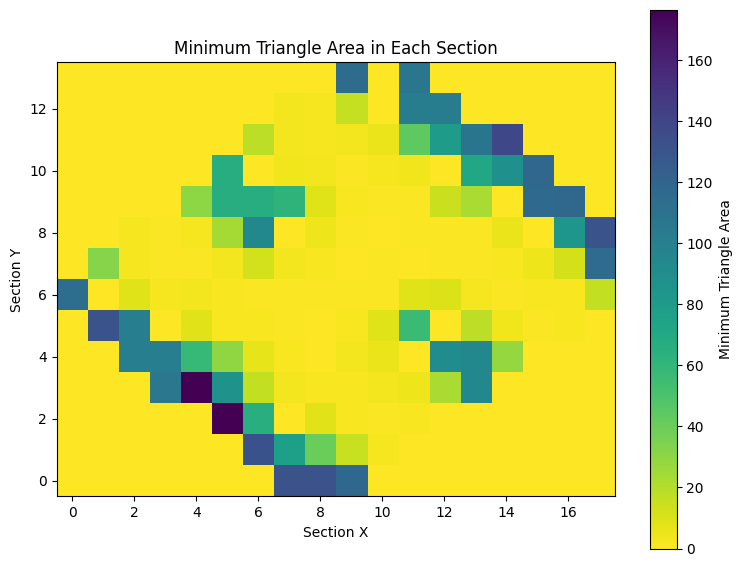

In [32]:
# Create heatmaps for minimum triangle area
plt.figure(figsize=(9,7))
plt.imshow(min_area_array, cmap='viridis_r', origin='lower', interpolation='nearest')
plt.colorbar(label='Minimum Triangle Area')
plt.xlabel('Section X')
plt.ylabel('Section Y')
plt.title('Minimum Triangle Area in Each Section')
#plt.grid(visible=False)
plt.show()

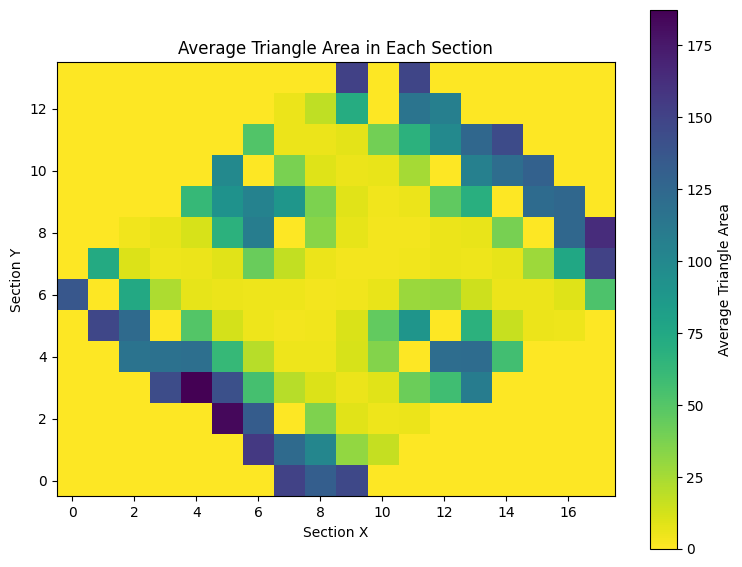

In [33]:
# Create heatmaps for average triangle area
plt.figure(figsize=(9,7))
plt.imshow(average_area_array, cmap='viridis_r', origin='lower', interpolation='nearest')
plt.colorbar(label='Average Triangle Area')
plt.xlabel('Section X')
plt.ylabel('Section Y')
plt.title('Average Triangle Area in Each Section')
#plt.grid(visible=False)
plt.show()

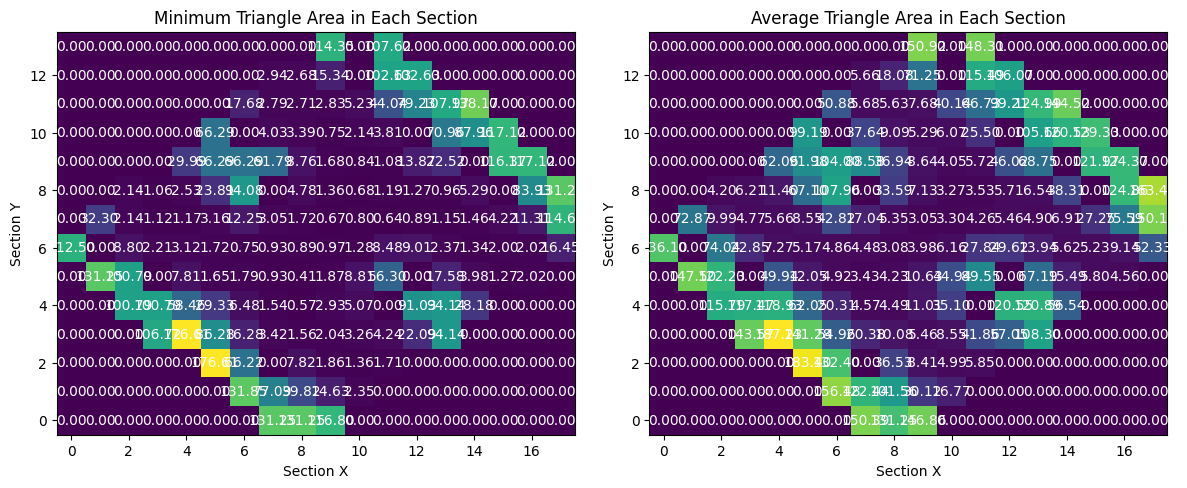

In [34]:
# Set the figure size
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Change the figsize values as per your requirement

# Create heatmap for minimum triangle area
axes[0].imshow(min_area_array, cmap='viridis', origin='lower', interpolation='nearest')
axes[0].set_xlabel('Section X')
axes[0].set_ylabel('Section Y')
axes[0].set_title('Minimum Triangle Area in Each Section')
#axes[0].grid(True)
#axes[0].colorbar(label='Minimum Triangle Area')
# Add text annotations to each box of the heatmap
for section_y in range(num_sections_y):
    for section_x in range(num_sections_x):
        text = axes[0].text(section_x, section_y, f'{min_area_array[section_y, section_x]:.2f}',
                            ha='center', va='center', color='w')

# Create heatmap for average triangle area
axes[1].imshow(average_area_array, cmap='viridis', origin='lower', interpolation='nearest')
axes[1].set_xlabel('Section X')
axes[1].set_ylabel('Section Y')
axes[1].set_title('Average Triangle Area in Each Section')
#axes[1].colorbar(label='Average Triangle Area')
# Add text annotations to each box of the heatmap
for section_y in range(num_sections_y):
    for section_x in range(num_sections_x):
        text = axes[1].text(section_x, section_y, f'{average_area_array[section_y, section_x]:.2f}',
                            ha='center', va='center', color='w')

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [27]:
pip list

Package                       VersionNote: you may need to restart the kernel to use updated packages.

----------------------------- -------
asttokens                     2.2.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.5
colorama                      0.4.6
comm                          0.1.4
contourpy                     1.1.0
cycler                        0.11.0
debugpy                       1.6.7
decorator                     5.1.1
executing                     1.2.0
fonttools                     4.42.0
importlib-metadata            6.8.0
ipykernel                     6.25.1
ipython                       8.14.0
jedi                          0.19.0
jupyter_client                8.3.0
jupyter_core                  5.3.1
kiwisolver                    1.4.4
matplotlib                    3.7.2
matplotlib-inline             0.1.6
nest-asyncio                  1.5.6
numpy                         1.25.2
numpy-stl                     3.0.1
packaging               

In [21]:
import skimage.measure
from skimage import io
import sys
np.set_printoptions(threshold=np.inf)

Number of disjoint objects: 3
Labeled Image:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


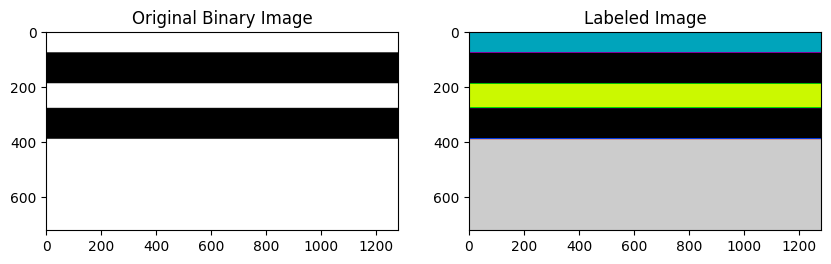

Number of disjoint objects: 3


In [13]:

# Load the binary image (black for objects, white for background)
image = io.imread('../data/test_images/ppt1.png', as_gray=True)

# Label connected components in the image
labeled_image = skimage.measure.label(image)

# Count the number of disjoint objects
num_objects = labeled_image.max()

print("Number of disjoint objects:", num_objects)

# Print the labeled image for inspection
print("Labeled Image:")
print(labeled_image)

# Display the original image and labeled image for visual inspection
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title("Original Binary Image")
plt.subplot(122)
plt.imshow(labeled_image, cmap='nipy_spectral')
plt.title("Labeled Image")
plt.show()

print("Number of disjoint objects:", num_objects)



In [22]:
print(labeled_image)

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Number of disjoint objects: 3
Labeled Image:
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]]


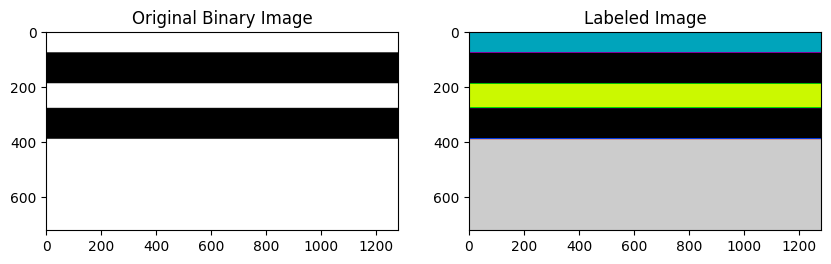

Number of disjoint objects: 3


In [11]:
calculate_disjoint_image()